In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
%load_ext autoreload
%autoreload 2
import model.dataset as ds
import model.models
import scipy.spatial.distance as ssdist
import librosa
import librosa.display
import matplotlib.pyplot as plt
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import pandas as pd
from pydub import AudioSegment as auseg

In [2]:
torch.cuda.empty_cache()

### Loading the dataset

set up dataloader

In [25]:
# path = '/home/ubuntu/datasets/processed/mixer/2-20000-2/test';
path = '/home/ubuntu/datasets/processed/datagen/2-s_5-c/train.csv';

# d = ds.SignalDataset(root_dir=path, transform=ds.Concat(size=(129, 231), encdec=True))
# d = ds.SignalDataset(root_dir=new, transform=ds.ToTensor(size=(129, 690)))
d = ds.MixtureDataset(num_sources=2, instruction_path=path, transform=ds.Wav2Spect('Concat', enc_dec=True))

In [26]:
dataloader = torch.utils.data.DataLoader(d, batch_size=128, shuffle=False)

In [27]:
for i, info in enumerate(dataloader):
    print(i)
    aggregate = info['aggregate']
    ground_truths_in = info['ground_truths_in']
    ground_truths_gt = info['ground_truths_gt']
#     break
_, seq_len, input_dim = aggregate.shape
print(aggregate.shape)
print(ground_truths_in.shape)
print(ground_truths_gt.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
torch.Size([32, 460, 258])
torch.Size([32, 461, 516])
torch.Size([32, 460, 2, 258])


In [10]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)
    
def get_spect(data, fs, nperseg, noverlap):
    r = np.split(data.numpy().T, 2)[0]
    i = np.split(data.numpy().T, 2)[1]
    c = r + 1j * i
    
    rev = scipy.signal.istft(c, fs=fs, nperseg=nperseg, noverlap=noverlap)
    return c, rev

def get_gt_spect(ground_truths_gt, ground_truths_in, fs, nperseg, noverlap, xid=0):
    _, seq_len, nsource, input_dim = ground_truths_gt.shape
    
    c_gts = []
    c_ins = []
    revs = []
    for i in range(nsource):
        gt = ground_truths_gt[xid, :, i]
        gt_in = ground_truths_in.view(-1, seq_len+1, nsource, input_dim)[xid, :, i]
        c_gt, rev = get_spect(gt, fs, nperseg, noverlap)
        c_in, _ = get_spect(gt_in, fs, nperseg, noverlap)

        c_gts.append(c_gt)
        c_ins.append(c_in)
        revs.append(rev)
    
    return c_gts, c_ins, revs

visualize sample data

In [12]:
xid = 2
nsource = 2
fs = 44100
nperseg = 256
noverlap = nperseg // 4

c_agg, agg_data = get_spect(aggregate[xid], fs=fs, nperseg=nperseg, noverlap=noverlap)
c_gts, c_ins, revs = get_gt_spect(ground_truths_gt, ground_truths_in, fs, nperseg, noverlap, xid)

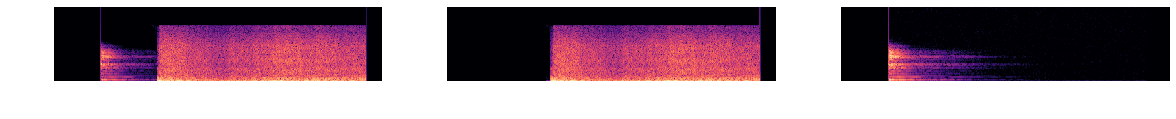

In [13]:

fig = plt.figure(figsize=(20, 3))
cs = [c_agg] + c_gts
for i, c in enumerate(cs):
    plt.subplot(2, 3, i + 1)
    display(c, fs)
    plt.axis('off')


In [14]:
import scipy.io.wavfile
from scipy.fftpack import dct
import scipy.signal
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt

# _, rdata = scipy.signal.istft(c, fs=44100, nfft = 256)
# IPython.display.Audio(data=rdata, rate=44100)

transformer model

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
512,3,4,128,64
512,4,4,128,128,
VTF,euclidean,2-20000-2,Min,1,72,400,0.001,Adam,128,0.5,0.0,0.9,0.99,1e-09,512,16,16,4,4,128,128,8.758085429668427,/home/ubuntu/multimodal-listener/results/2-20000-2_euclidean_VTF_Min_190723/config_0/snapshots/best.tar,0.05


In [16]:
import model.transformer
_, seq_len, freq_range = aggregate.shape
print(seq_len)
print(freq_range)
net = model.transformer.make_model(freq_range, num_sources=2, N=4, d_model=128, d_ff=128, h=4,dropout=0.5).to(device)
# checkpoint = torch.load('/home/ubuntu/multimodal-listener/results/2-20000-2_euclidean_VTF_190723/config_0/snapshots/best.tar')

# net.load_state_dict(checkpoint['model_state_dict'])
# checkpoint


460
258


In [17]:
from torch.autograd import Variable
subseq_mask = model.transformer.subsequent_mask(ground_truths_in.shape[1])
subseq_mask = Variable(subseq_mask).type_as(aggregate.data).to(device)

In [18]:
print(subseq_mask.shape)
# plt.figure(figsize=(5,5))
# plt.imshow(subseq_mask.cpu()[0])

torch.Size([1, 461, 461])


In [19]:
out = net(aggregate.to(device), ground_truths_in.to(device), None, subseq_mask.to(device))

aggregate

In [20]:
IPython.display.Audio(data=agg_data, rate=fs)

predicted separations

In [22]:
IPython.display.Audio(data=revs[0], rate=fs)

In [24]:
IPython.display.Audio(data=revs[1], rate=fs)

### Greedy decoding

In [136]:
seps = model.transformer.greedy_decoder(net, aggregate.to(device), seq_len, 2, freq_range, device)

In [137]:
print(seps.shape)
# pp = seps.view(-1, seq_len, 2, 258)
pp = torch.split(seps, 258, dim=-1)
oo = torch.stack(pp, dim=2)
print(oo.shape)

torch.Size([4, 231, 516])
torch.Size([4, 231, 2, 258])


In [138]:
def get_pred_spect(pp, num_sources, xid=0):
    cs = []
    for i in range(num_sources):
        g = pp[xid, :, i, :].cpu().numpy().T
        r = np.split(g, 2)[0]
        i = np.split(g, 2)[1]
        c = r + 1j * i
        cs.append(c)
    return cs

def get_pred_spect(ground_truths_gt, fs, nperseg, noverlap, xid=0):
    _, seq_len, nsource, input_dim = ground_truths_gt.shape
    
    c_gts = []
    revs = []
    for i in range(nsource):
        gt = ground_truths_gt[xid, :, i].cpu()
        c_gt, rev = get_spect(gt, fs, nperseg, noverlap)

        c_gts.append(c_gt)
        revs.append(rev)
    
    return c_gts, revs

def plot_cs(cs, dim):
    fig = plt.figure(figsize=(20, 3))
    cs = [c_agg] + cs
    for i, c in enumerate(cs):
        plt.subplot(dim[0], dim[1], i + 1)
        display(c, 22050)
        plt.axis('off')

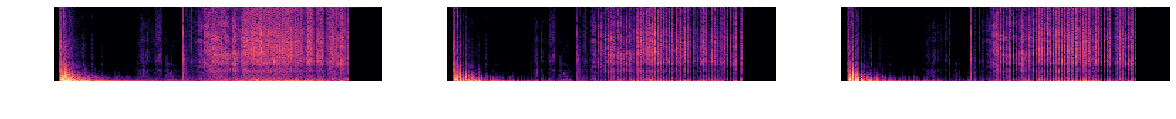

In [139]:
# cs = get_pred_spect(pp, 2, xid=0)
cs, revvs = get_pred_spect(oo, fs, nperseg, noverlap, xid)
plot_cs(cs, dim=(2, 3))

### random experiments

In [ ]:
a = torch.arange(12).view(4, 3)
a1 = a[:2].view(-1, 3)
a2 = a[2:].view(-1, 3)

print(a1)
print(a2)

print(torch.cat([a1, a2]))
print(torch.cat([a1, a2]).shape)
# print(a.sha)

In [ ]:
aa = torch.arange(12.).view(3, 4)
a = aa.view(4, 3)
# b = torch.ones(4, 3).copy_(a)
b = torch.cat([torch.ones(3).view(1,3), a])

print(aa)
print(a)
print(b)
aa.fill_(10)
print(a)
print(b)


In [ ]:
torch.ones(2, 3)
torch.zeros(2, 3)

In [ ]:

def check(m_c, m):
    for i in range(m_c.shape[0]):
        for j in range(m_c.shape[1]):
            batch = i // m.shape[1]
            ii = i % m.shape[1]
            assert(m_c[i][j] == m[batch][ii][j])
    print("passed")

check(agg_concat, agg)